Spatial Coherence: 149.03655528437375
Clustering Factor: 4.566582573784722
Gabor Feature - Mean: 254.93862915039062
Gabor Feature - Standard Deviation: 3.7721806989577074
Uniformity of Frequency Field: 712860823.75
Ridge Frequency: 6.735548879878222e-06
Direction Map - Mean Direction: -12.698662945372687
Low Contrast Map - Mean Contrast: 0.0916788
0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.33      1.00      0.50         2

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6



c:\Users\cioba\miniconda3\envs\bogdan\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cioba\miniconda3\envs\bogdan\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cioba\miniconda3\envs\bogdan\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


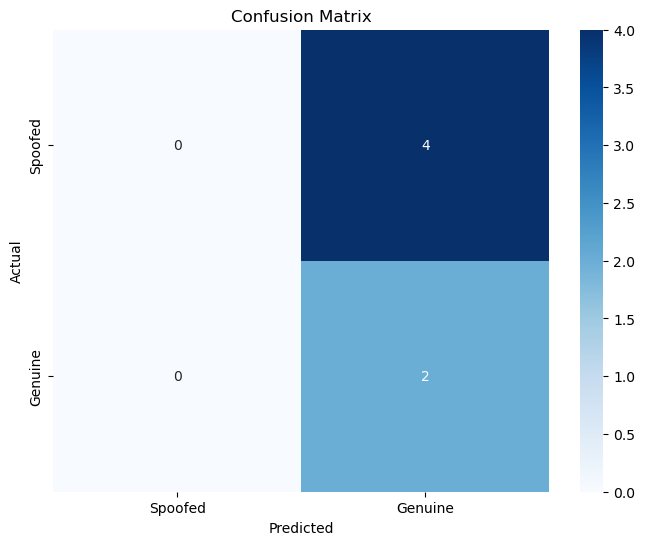

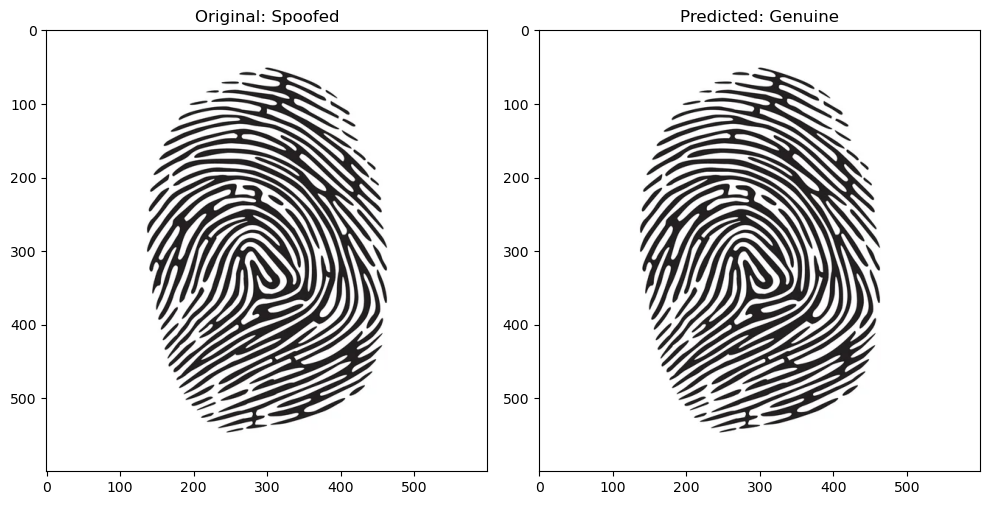

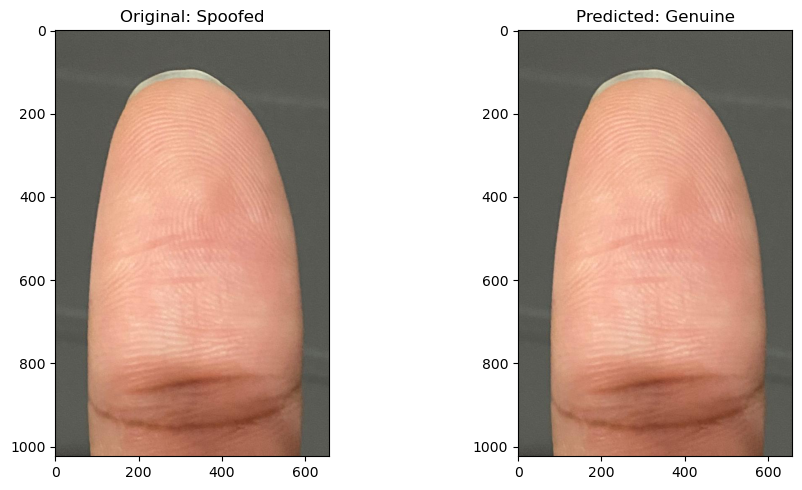

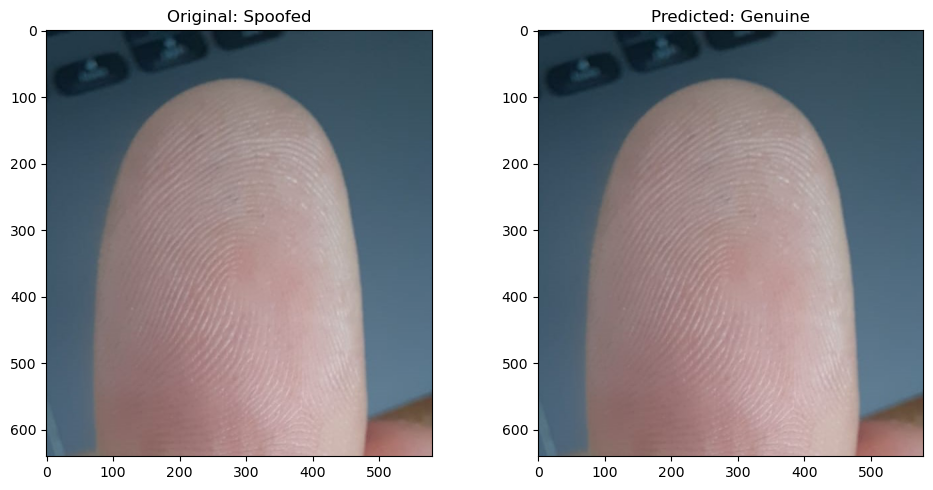

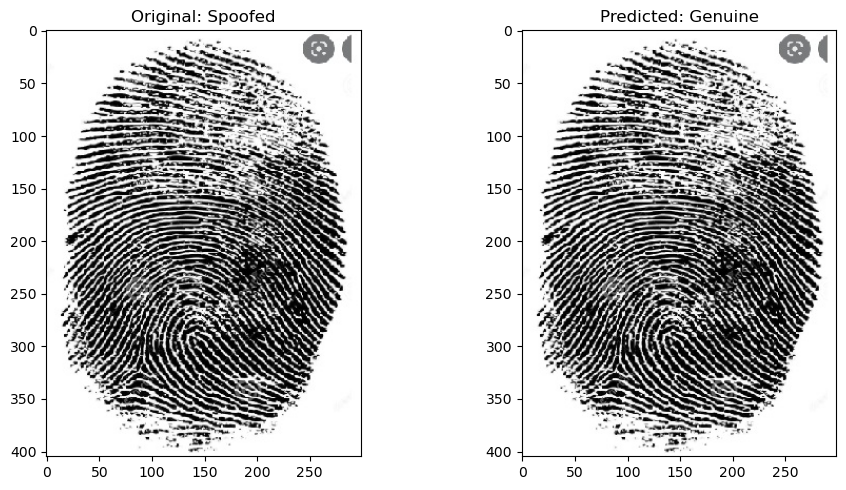

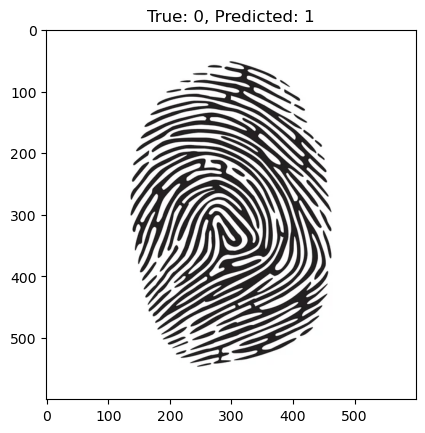

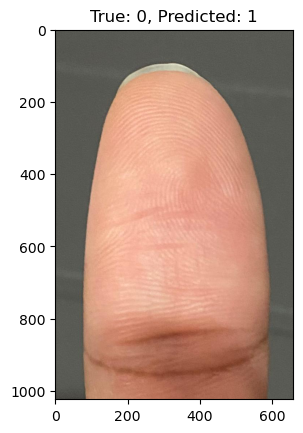

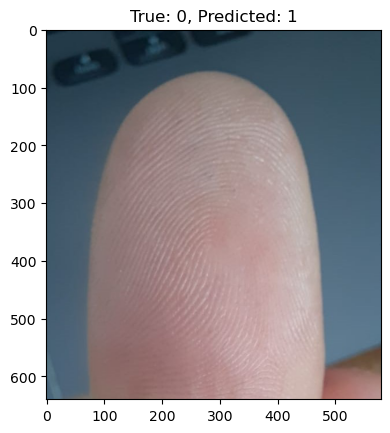

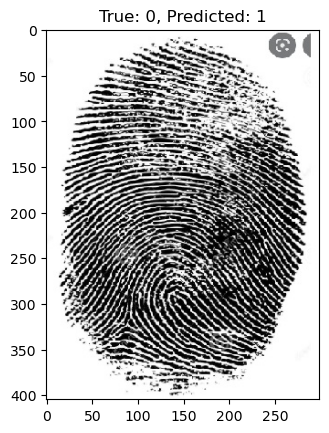

In [7]:
import cv2
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

def get_image_files_from_directory(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.jpg', '.jpeg'))]

genuine_images = get_image_files_from_directory("genuine")
spoofed_images = get_image_files_from_directory("spoofed")




def spatial_coherence(image):
    # Calculează gradientul
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculează magnitudinea gradientului
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Magnitudinea medie poate fi utilizată ca o măsură a coerenței spațiale
    coherence = np.mean(magnitude)
    
    return coherence

def clustering_factor(image):
    # Binarizează imaginea
    _, binarized = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    
    # Definește un nucleu 3x3
    kernel = np.ones((3, 3), np.uint8)
    
    # Numără pixelii negri în vecinătatea 3x3
    black_count = cv2.filter2D(binarized, -1, kernel)
    
    # Calculează factorul de grupare
    cluster_factor = np.mean(black_count) / 9.0  # Normalizează în funcție de dimensiunea nucleului
    
    return cluster_factor

def gabor_feature(image):
    # Definește parametrii nucleului Gabor
    ksize = 31
    sigma = 4.0
    theta = np.pi / 4  # 45 de grade
    lambd = 10.0
    gamma = 0.5
    psi = 0
    
    # Aplică filtrul Gabor
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
    
    # Calculează media și deviația standard ca caracteristici
    mean = np.mean(filtered_image)
    std = np.std(filtered_image)
    
    return mean, std

def uniformity_of_frequency_field(image):
    # Calculează gradientul
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculează magnitudinea și orientarea gradientului
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    orientation = np.arctan2(sobely, sobelx) * (180 / np.pi)
    
    # Calculează frecvența orientărilor
    hist, _ = np.histogram(orientation, bins=8, range=(-180, 180))
    
    # Uniformitatea este varianța histogramăi
    uniformity = np.var(hist)
    
    return uniformity

def ridge_frequency(image):
    # Calculează gradientul
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculează orientarea gradientului
    orientation = np.arctan2(sobely, sobelx) * (180 / np.pi)
    
    # Calculează frecvența orientărilor
    hist, _ = np.histogram(orientation, bins=8, range=(-180, 180))
    
    # Frecvența crestei este inversul numărului celei mai comune orientări
    frequency = 1.0 / np.max(hist)
    
    return frequency

def direction_map(image):

    # Calcul graditent
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    
    # Orientarea gradientului
    orientation = np.arctan2(sobely, sobelx) * (180 / np.pi)
    
    return orientation

def low_contrast_map(image, block_size=16):

    height, width = image.shape
    contrast_map = np.zeros_like(image, dtype=np.float32)
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            block = image[y:y+block_size, x:x+block_size]
            contrast = np.std(block)
            contrast_map[y:y+block_size, x:x+block_size] = contrast
            
    # Normalizam contrast_map
    contrast_map = (contrast_map - np.min(contrast_map)) / (np.max(contrast_map) - np.min(contrast_map))
    
    return contrast_map

def extract_features_from_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    features = [
        spatial_coherence(image),
        clustering_factor(image),
        gabor_feature(image)[0],  # Mean
        gabor_feature(image)[1],  # Std
        uniformity_of_frequency_field(image),
        ridge_frequency(image),
        np.mean(direction_map(image)),
        np.mean(low_contrast_map(image))
    ]
    return features





# Test functii pentru doar o imagine
image_path = "imagine_deget_eu.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

print("Spatial Coherence:", spatial_coherence(image))
print("Clustering Factor:", clustering_factor(image))

gabor_mean, gabor_std = gabor_feature(image)
print("Gabor Feature - Mean:", gabor_mean)
print("Gabor Feature - Standard Deviation:", gabor_std)

uniformity = uniformity_of_frequency_field(image)
print("Uniformity of Frequency Field:", uniformity)

ridge_freq = ridge_frequency(image)
print("Ridge Frequency:", ridge_freq)

dir_map = direction_map(image)
print("Direction Map - Mean Direction:", np.mean(dir_map))

contrast_map = low_contrast_map(image)
print("Low Contrast Map - Mean Contrast:", np.mean(contrast_map))








# extrage features pentru fiecare imagine
X_genuine = [extract_features_from_image(img_path) for img_path in genuine_images]
X_spoofed = [extract_features_from_image(img_path) for img_path in spoofed_images]

# 1 = true , 0 = fake
y_genuine = [1] * len(X_genuine)
y_spoofed = [0] * len(X_spoofed)

# Iau toate datele
X_combined = X_genuine + X_spoofed
y = y_genuine + y_spoofed


# Le impart in test si train
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.4, random_state=42)


#   X_train si X_test sunt liste de feature list (altfel eroare)
X_train_data = [x[1] for x in X_train]
X_test_data = [x[1] for x in X_test]

X_train_data = np.array(X_train_data).reshape(len(X_train_data), -1)
X_test_data = np.array(X_test_data).reshape(len(X_test_data), -1)

# SVM TRAINING
clf = svm.SVC()
clf.fit(X_train_data, y_train)

# Prezicere pe setul de test
y_pred = clf.predict(X_test_data)


# Evalueaza
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matrice confusion pentru vizualizare
cm = confusion_matrix(y_test, y_pred)
labels = ["Spoofed", "Genuine"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# Care imagini sunt clasificate gresit
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]

# Afisare imagini clasificate gresit
for index in misclassified_indices:
    img_path = genuine_images[index] if y_test[index] == 1 else spoofed_images[index]
    image = cv2.imread(img_path)
    
    # Afisare imagine originala
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Original: {labels[y_test[index]]}")
    
    # arata aceeasi imagine
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {labels[y_pred[index]]}")
    
    plt.tight_layout()
    plt.show()

# doar asa extra sa imi zica care e clasificata gresit

for index in misclassified_indices:
    img_path = genuine_images[index] if y_test[index] == 1 else spoofed_images[index]
    image = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {y_test[index]}, Predicted: {y_pred[index]}")
    plt.show()